<a href="https://colab.research.google.com/github/pandu1992/PPB_Research/blob/main/PIB_Inert_Alert_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 2021.xlsx to 2021.xlsx
Saving 2022.xlsx to 2022.xlsx
Saving 2023.xlsx to 2023.xlsx


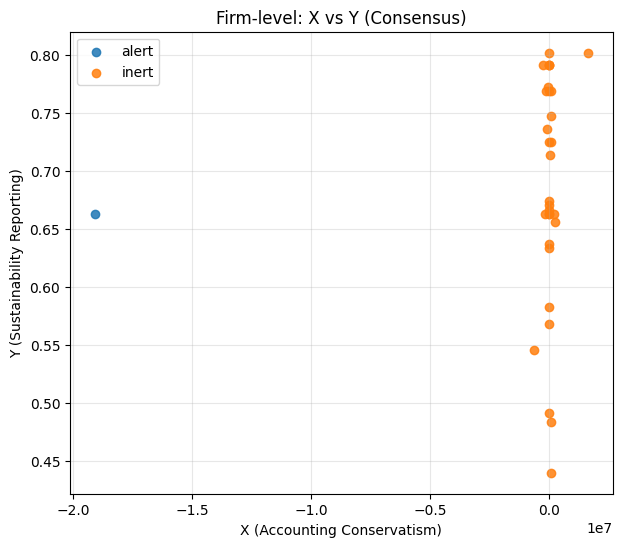

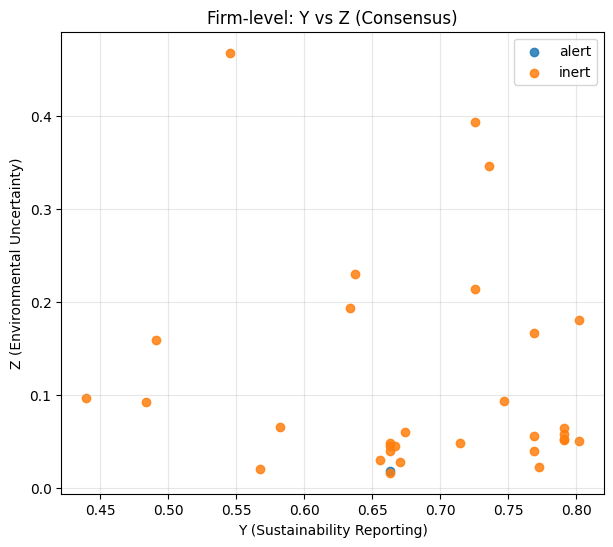

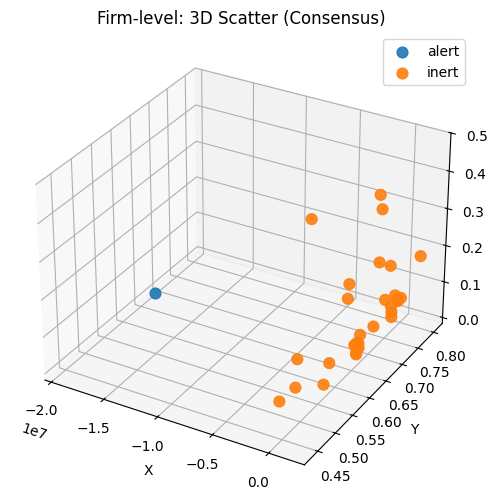

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,0.178787,0.006677,0.026104
1,-5.542393,-0.206995,-0.809234


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,2.786598e+04,0.683800,0.112122
1,-1.910228e+07,0.663004,0.018526


File tersimpan: inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (1).xlsx
Saving 2022.xlsx to 2022 (1).xlsx
Saving 2023.xlsx to 2023 (1).xlsx


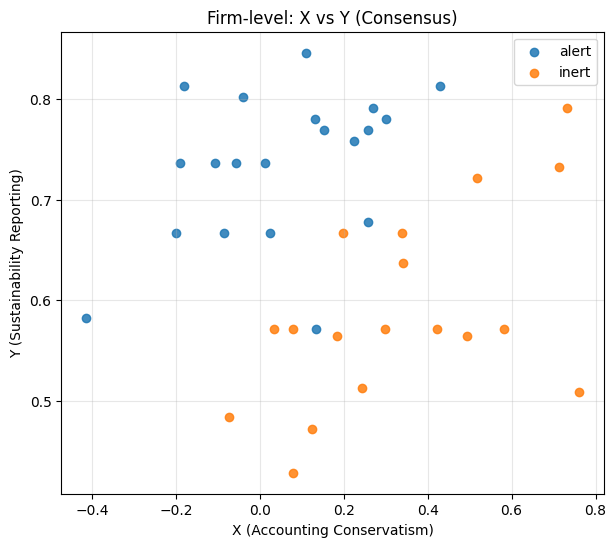

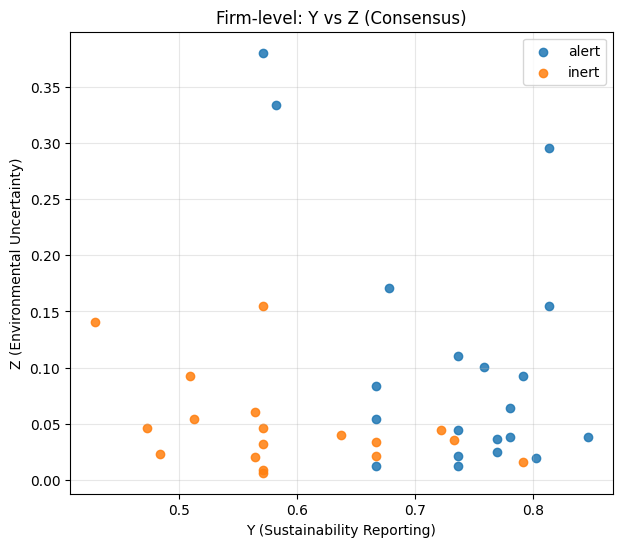

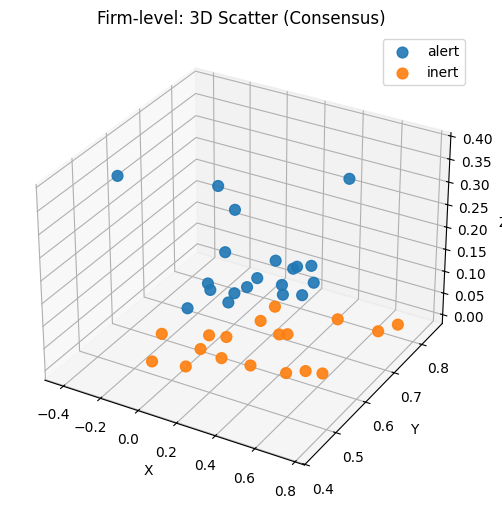

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,0.561894,-0.691904,-0.335556
1,-0.505704,0.622714,0.302000


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,0.336954,0.589337,0.048899
1,0.051368,0.734982,0.104500


File tersimpan: Bahan Baku_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Bahan Baku_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (2).xlsx
Saving 2022.xlsx to 2022 (2).xlsx
Saving 2023.xlsx to 2023 (2).xlsx


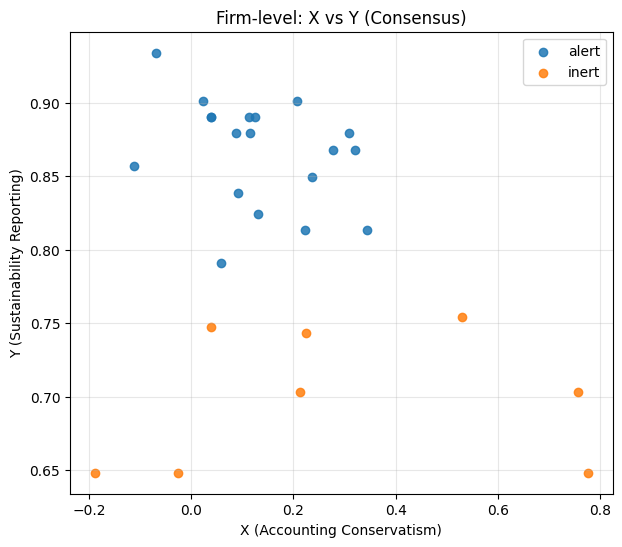

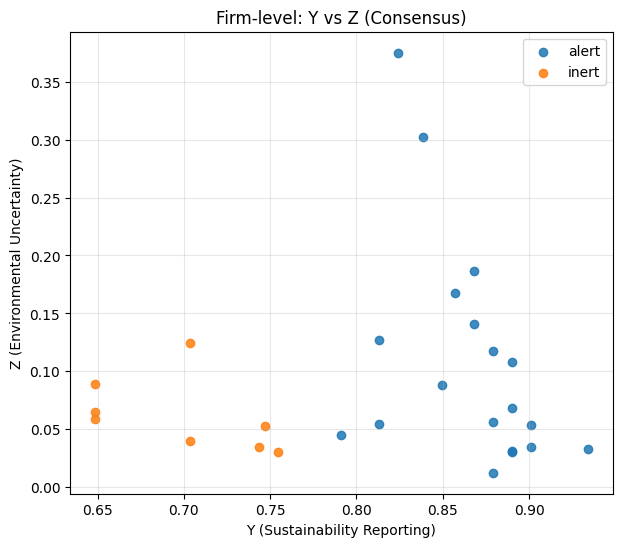

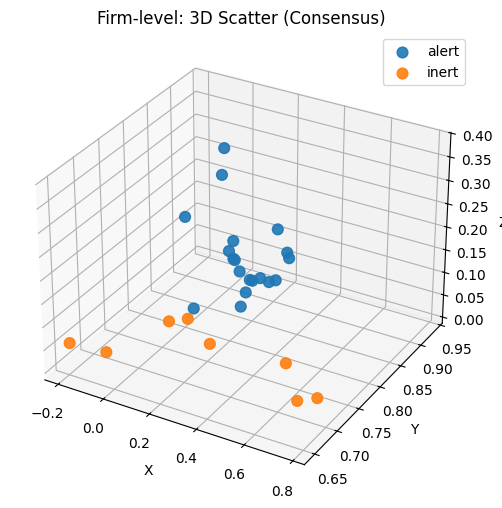

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,0.491347,-1.378290,-0.384377
1,-0.206883,0.580333,0.161843


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,0.290585,0.699634,0.061832
1,0.134365,0.866204,0.107039


File tersimpan: Industri_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Industri_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (3).xlsx
Saving 2022.xlsx to 2022 (3).xlsx
Saving 2023.xlsx to 2023 (3).xlsx


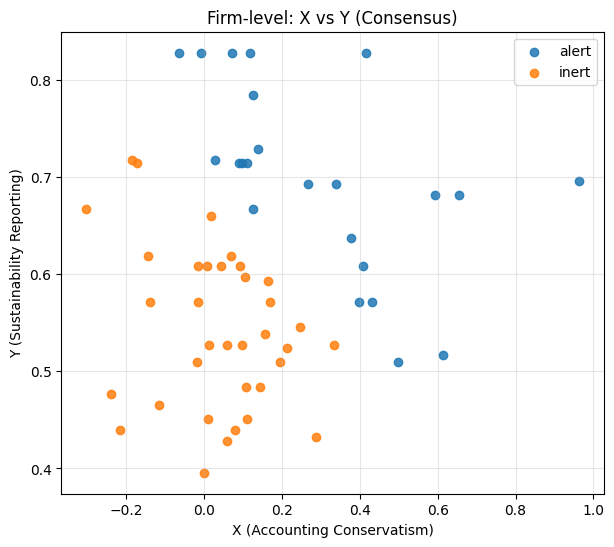

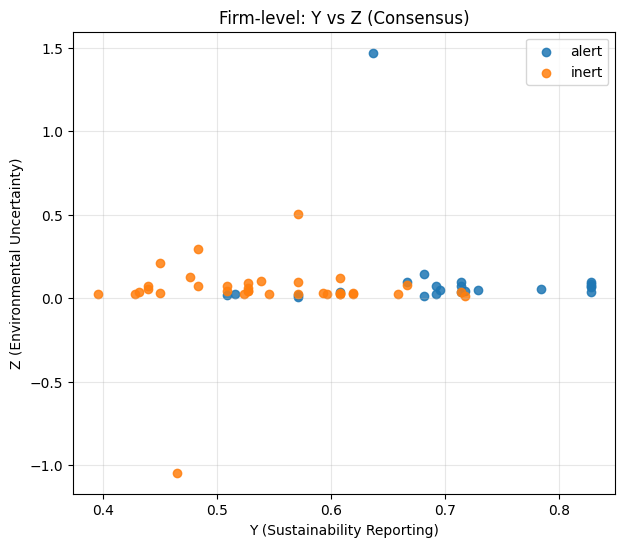

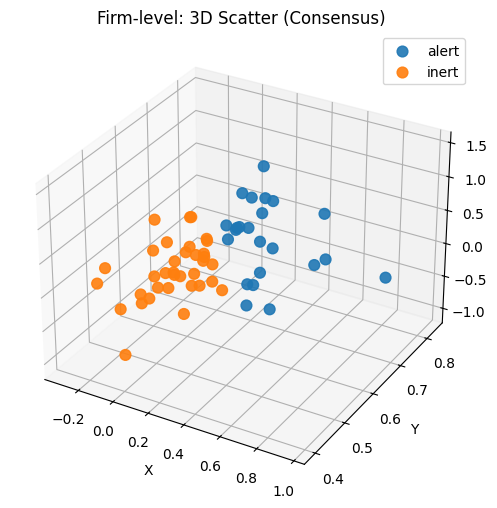

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,-0.442409,-0.530309,-0.118353
1,0.673231,0.806992,0.180102


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,0.034438,0.543276,0.044361
1,0.295377,0.697245,0.118004


File tersimpan: Konsumen Primer_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Konsumen Primer_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (4).xlsx
Saving 2022.xlsx to 2022 (4).xlsx
Saving 2023.xlsx to 2023 (4).xlsx


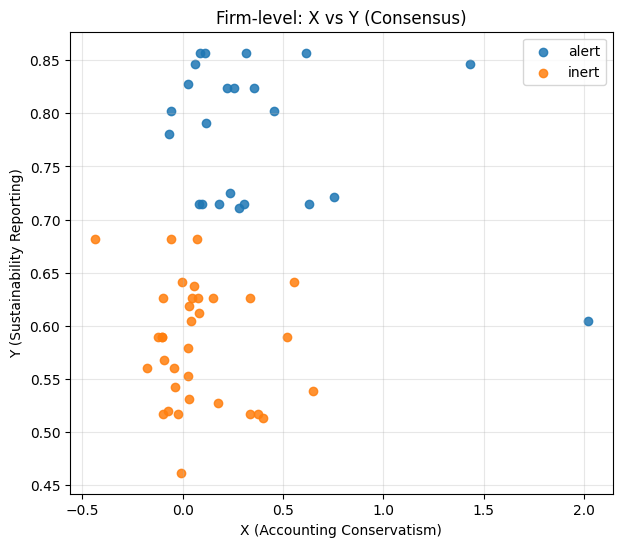

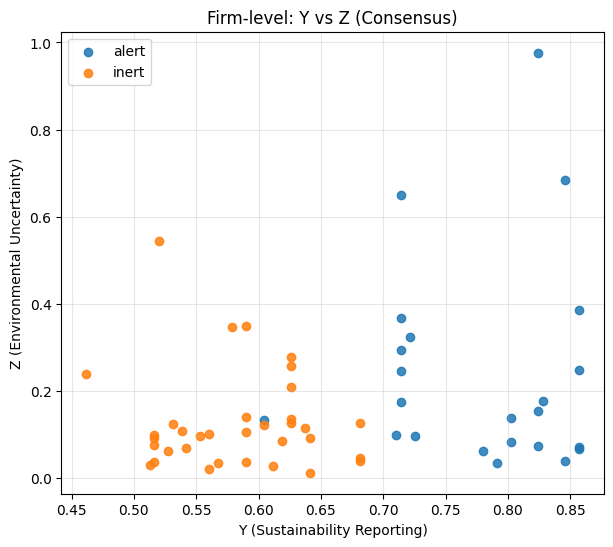

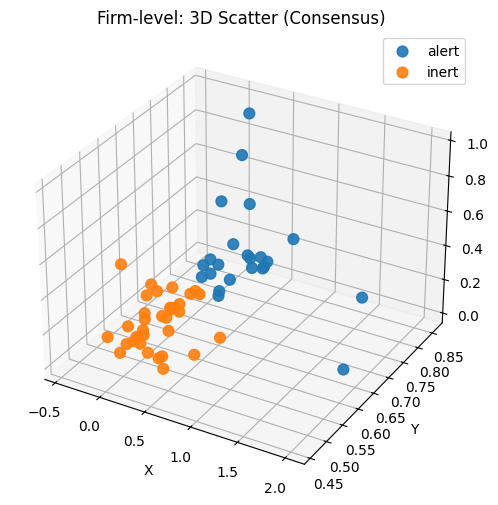

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,-0.316256,-0.696826,-0.253435
1,0.467509,1.030090,0.374642


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,0.073672,0.582633,0.128381
1,0.369432,0.779583,0.242102


File tersimpan: Konsumen Non-Primer_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Konsumen Non-Primer_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (5).xlsx
Saving 2022.xlsx to 2022 (5).xlsx
Saving 2023.xlsx to 2023 (5).xlsx


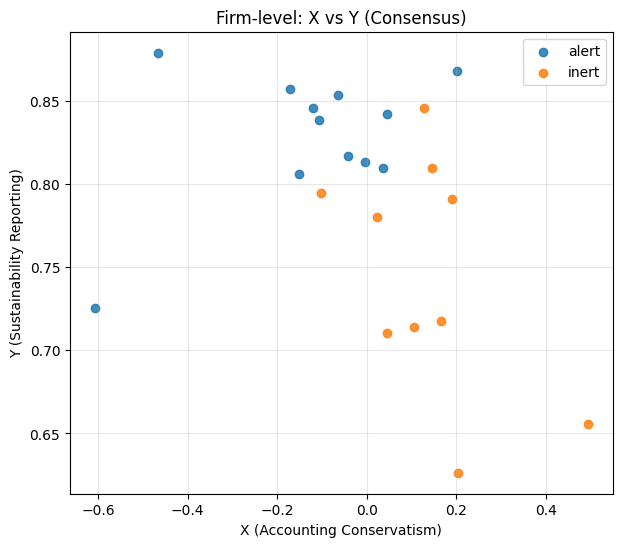

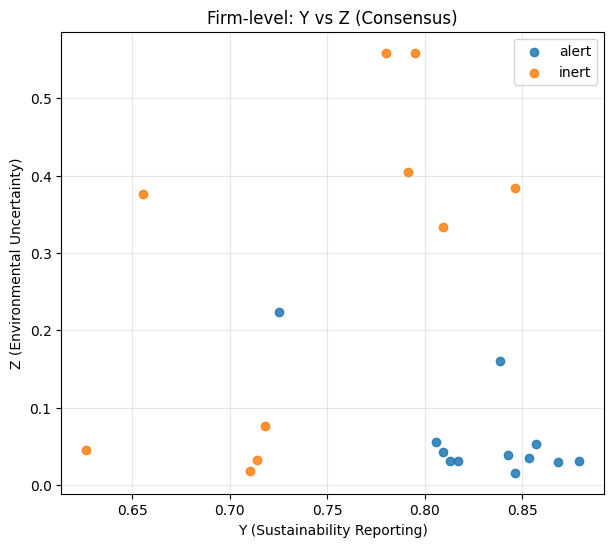

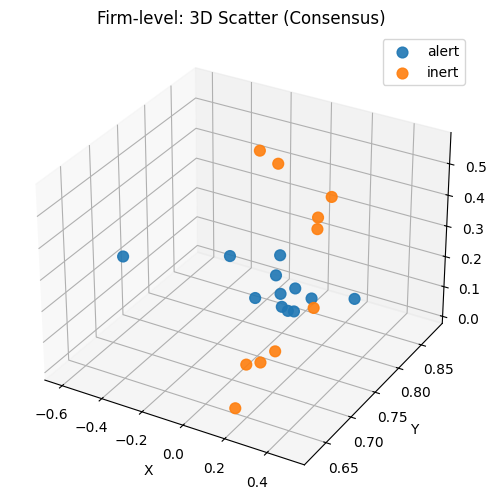

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,-0.524018,0.565556,-0.544907
1,0.628821,-0.678667,0.653888


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,-0.120715,0.829670,0.061978
1,0.140031,0.744689,0.278890


File tersimpan: Kesehatan_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Kesehatan_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (6).xlsx
Saving 2022.xlsx to 2022 (6).xlsx
Saving 2023.xlsx to 2023 (6).xlsx


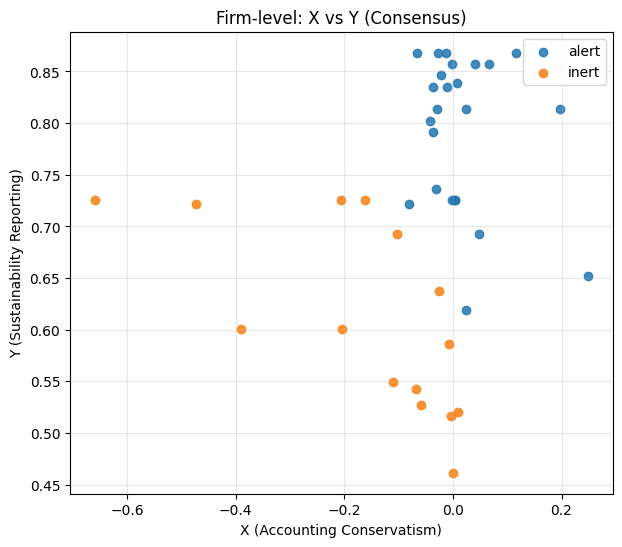

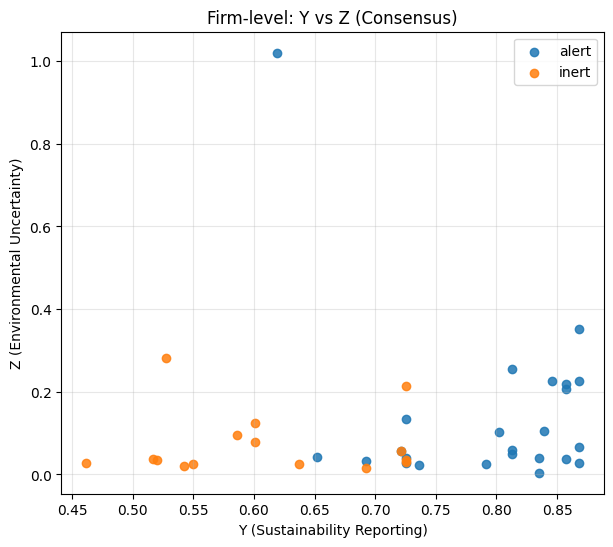

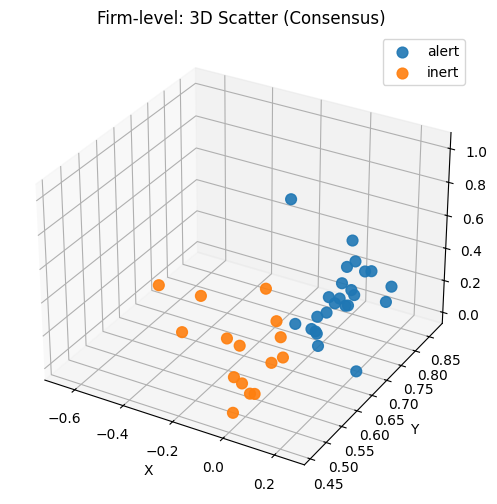

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,0.435383,0.593861,0.151067
1,-0.696613,-0.950178,-0.241707


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,0.015833,0.792888,0.140789
1,-0.163969,0.608791,0.073728


File tersimpan: Keuangan_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Keuangan_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (7).xlsx
Saving 2022.xlsx to 2022 (7).xlsx
Saving 2023.xlsx to 2023 (7).xlsx


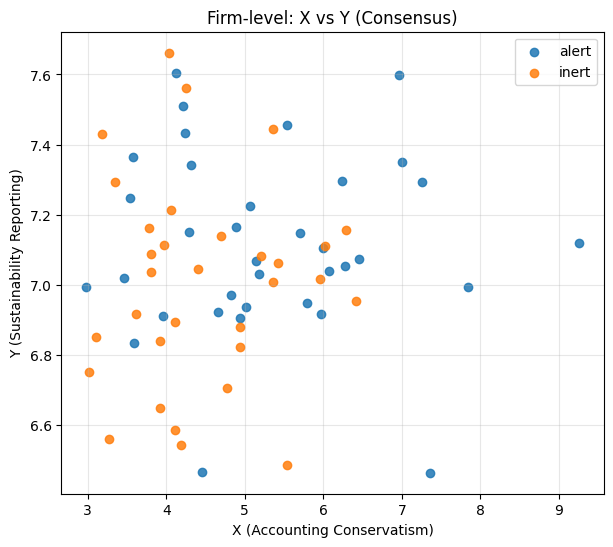

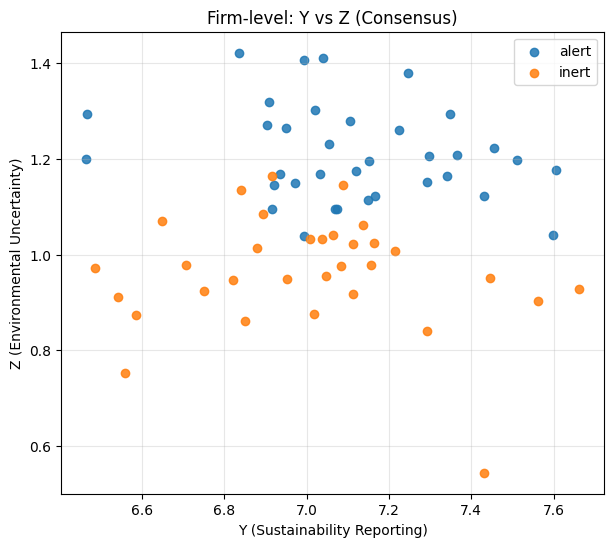

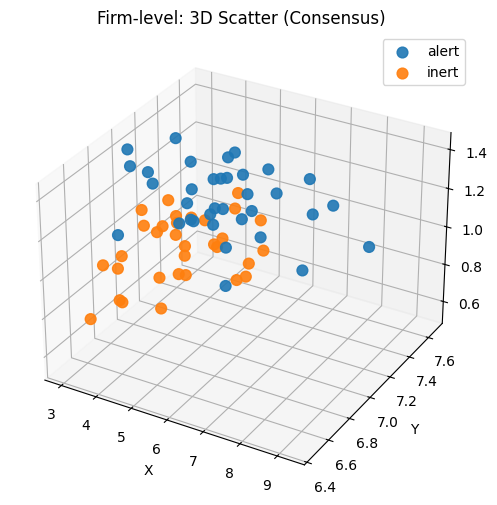

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,-0.351338,-0.209088,-0.785288
1,0.321224,0.191166,0.717978


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,4.462343,7.002239,0.964895
1,5.319793,7.113244,1.211256


File tersimpan: Properti dan Real Estate_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Properti dan Real Estate_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (8).xlsx
Saving 2022.xlsx to 2022 (8).xlsx
Saving 2023.xlsx to 2023 (8).xlsx


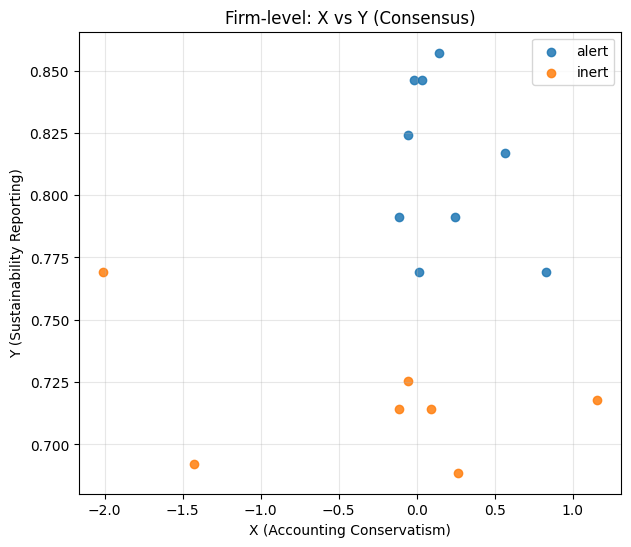

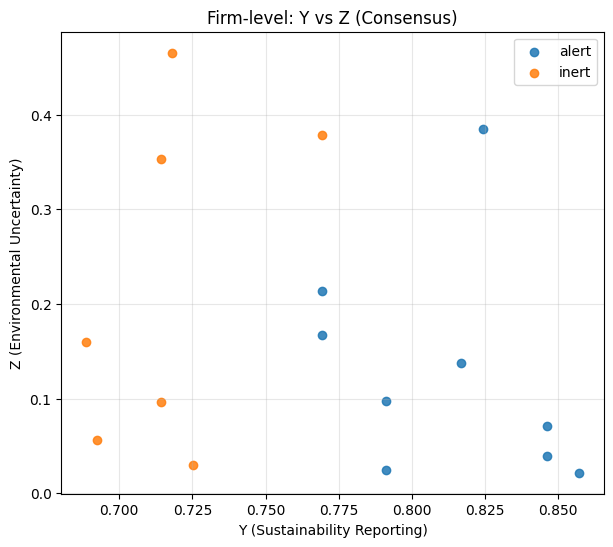

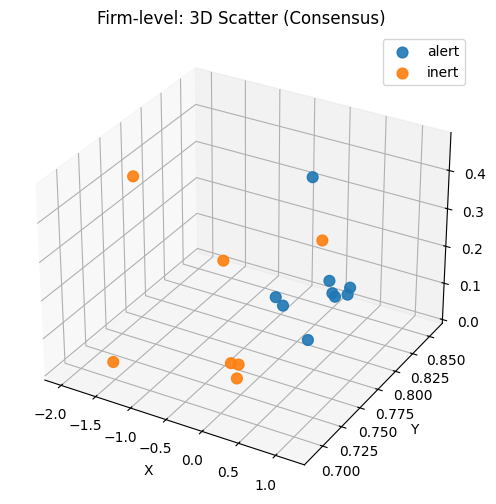

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,-0.369992,-0.967208,0.359404
1,0.287772,0.752273,-0.279536


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,-0.299568,0.717425,0.219859
1,0.182196,0.812373,0.128558


File tersimpan: Teknologi_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Teknologi_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (9).xlsx
Saving 2022.xlsx to 2022 (9).xlsx
Saving 2023.xlsx to 2023 (9).xlsx


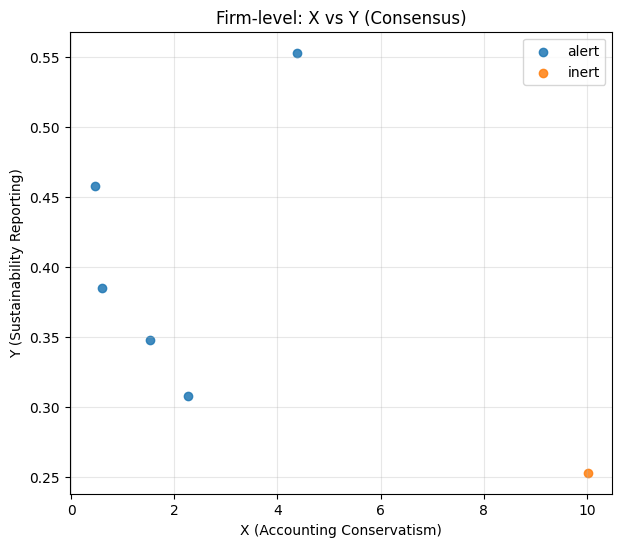

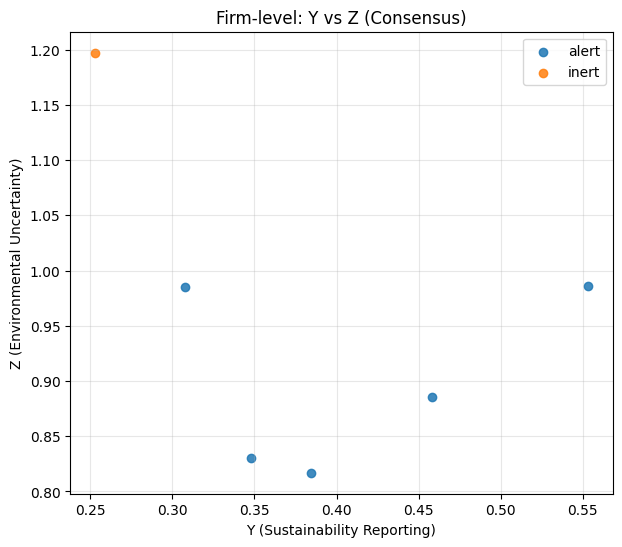

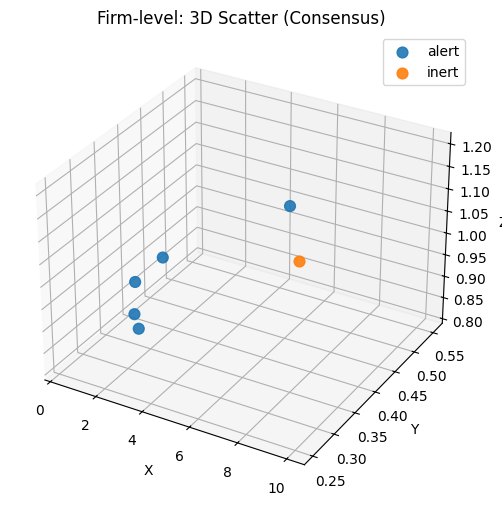

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,2.056069,-1.330383,1.914448
1,-0.411214,0.266077,-0.382890


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,10.015548,0.252747,1.197307
1,1.843193,0.410256,0.900921


File tersimpan: Infrastruktur_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Infrastruktur_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")


Saving 2021.xlsx to 2021 (10).xlsx
Saving 2022.xlsx to 2022 (10).xlsx
Saving 2023.xlsx to 2023 (10).xlsx


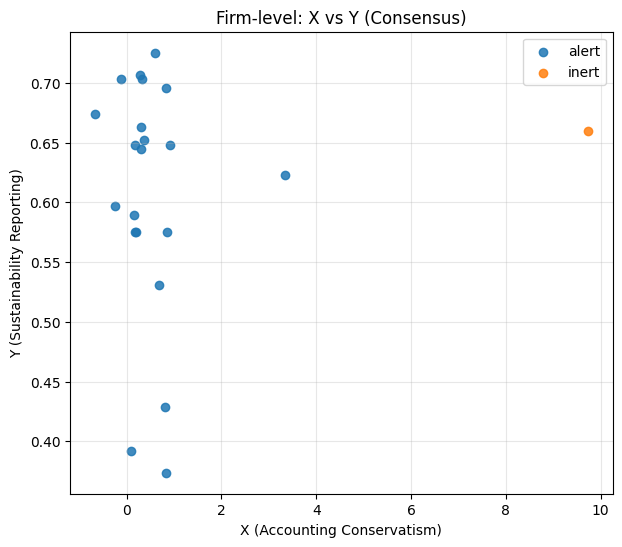

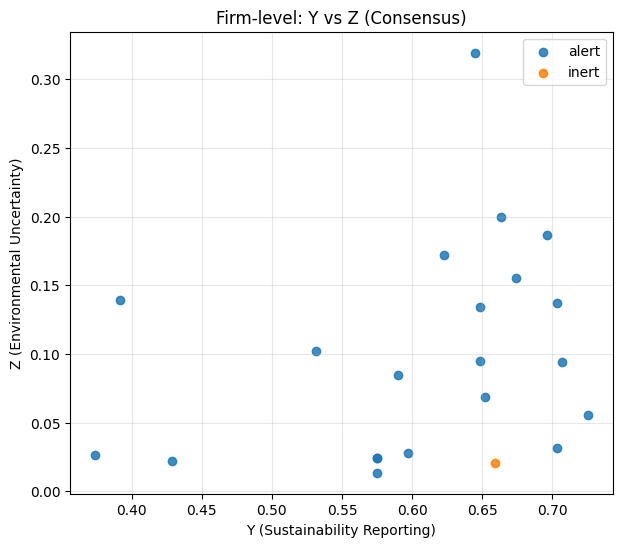

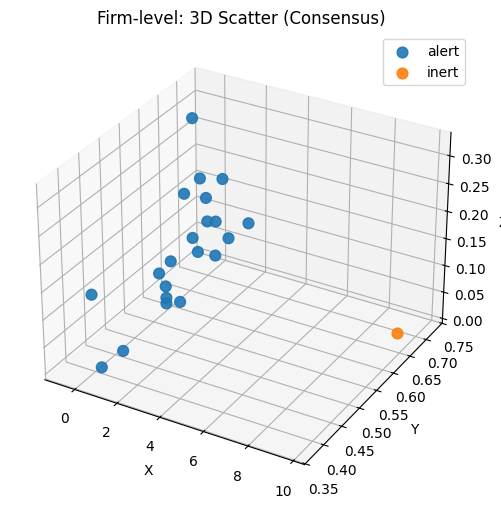

Centroid (scaled):


,X_scaled,Y_scaled,Z_scaled
Cluster_KM,,,
0,4.284445,0.521935,-1.003317
1,-0.204021,-0.024854,0.047777


Centroid (approx. unscaled):


,X,Y,Z
Cluster_KM,,,
0,9.72966,0.659341,0.020444
1,0.48489,0.605965,0.100550


File tersimpan: Transportasi dan Logistik_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx


In [ ]:
# ============================================================
# Unsupervised inert vs alert (firm-level mean of 2021–2023)
# ============================================================

# 0) Install
!pip install -q pandas scikit-learn openpyxl matplotlib

# 1) Upload 3 file Excel
from google.colab import files
import io, re
import numpy as np
import pandas as pd

uploaded = files.upload()  # pilih 2021.xlsx, 2022.xlsx, 2023.xlsx

# 2) Baca & gabung raw
def read_df_from_upload(fname, blob):
    df = pd.read_excel(io.BytesIO(blob))
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    required = {"No","Code","X","Y","Z"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Kolom wajib {miss} tidak ada di {fname}. Ada: {df.columns.tolist()}")
    for col in ["X","Y","Z"]:
        if df[col].dtype == "O":
            df[col] = (df[col].astype(str)
                               .str.replace(" ", "", regex=False)
                               .str.replace("\u00A0", "", regex=False)
                               .str.replace(",", ".", regex=False))
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["SourceFile"] = fname
    # Ambil tahun dari nama file jika ada
    m = re.search(r'(20\d{2})', fname)
    df["Year"] = int(m.group(1)) if m else np.nan
    return df

df_all_years = pd.concat([read_df_from_upload(fn, uploaded[fn]) for fn in uploaded], ignore_index=True)

# 3) Firm-level: rata-rata X,Y,Z per Code (representasi 3 tahun)
df_firm = (df_all_years.groupby("Code", as_index=False)
                        .agg({"X":"mean","Y":"mean","Z":"mean"}))

# 4) Scaling
from sklearn.preprocessing import StandardScaler
features = ["X","Y","Z"]
scaler = StandardScaler()
df_firm[[f"{c}_scaled" for c in features]] = scaler.fit_transform(df_firm[features])
X_mat = df_firm[["X_scaled","Y_scaled","Z_scaled"]].values

# 5) Clustering (unsupervised): KMeans & GMM (k=2)
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_mat)
df_firm["Cluster_KM"] = km.labels_
gmm = GaussianMixture(n_components=k, random_state=42).fit(X_mat)
df_firm["Cluster_GMM"] = gmm.predict(X_mat)

# 6) Internal metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def internal_metrics(X, labels, name):
    return {"model": name,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels)}
metrics_tbl = pd.DataFrame([
    internal_metrics(X_mat, df_firm["Cluster_KM"],  "KMeans"),
    internal_metrics(X_mat, df_firm["Cluster_GMM"], "GMM"),
])

# 7) Labeling heuristik pasca-cluster (tetap unsupervised)
def label_by_single_metric(df, cluster_col, metric, higher_is_alert=True):
    means = df.groupby(cluster_col)[metric].mean()
    alert_cluster = means.idxmax() if higher_is_alert else means.idxmin()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

def label_by_weighted_score(df, cluster_col, wx=0.2, wy=0.5, wz=0.3):
    # Skor teoretis: -X +Y +Z
    score = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    m = pd.DataFrame({"c": df[cluster_col], "s": score}).groupby("c")["s"].mean()
    alert_cluster = m.idxmax()
    return np.where(df[cluster_col]==alert_cluster, "alert", "inert")

cmain = "Cluster_KM"
df_firm["Label_Y_only"]   = label_by_single_metric(df_firm, cmain, "Y", higher_is_alert=True)
df_firm["Label_X_only"]   = label_by_single_metric(df_firm, cmain, "X", higher_is_alert=False)
df_firm["Label_Z_only"]   = label_by_single_metric(df_firm, cmain, "Z", higher_is_alert=True)
df_firm["Label_weighted"] = label_by_weighted_score(df_firm, cmain, wx=0.2, wy=0.5, wz=0.3)

# 8) Grid-search bobot terbaik untuk weighted label
def weighted_sep_score(df, cluster_col, wx, wy, wz):
    score_point = (-wx*df["X_scaled"] + wy*df["Y_scaled"] + wz*df["Z_scaled"])
    sep = pd.DataFrame({"c": df[cluster_col], "s": score_point}).groupby("c")["s"].mean().sort_values()
    return float(sep.iloc[-1] - sep.iloc[0])  # makin besar makin terpisah
rows = []
for wx in [0.1, 0.2, 0.3]:
    for wy in [0.4, 0.5, 0.6]:
        for wz in [0.2, 0.3, 0.4]:
            rows.append((wx, wy, wz, weighted_sep_score(df_firm, cmain, wx, wy, wz)))
grid_df = pd.DataFrame(rows, columns=["wX","wY","wZ","sep_score"]).sort_values("sep_score", ascending=False)
wx_b, wy_b, wz_b = grid_df.iloc[0][["wX","wY","wZ"]]
df_firm["Label_weighted_best"] = label_by_weighted_score(df_firm, cmain, wx=wx_b, wy=wy_b, wz=wz_b)

# 9) CONSENSUS: strict majority + tie-breaker (weighted_best)
votes = np.column_stack([
    df_firm["Label_Y_only"].eq("alert"),
    df_firm["Label_X_only"].eq("alert"),
    df_firm["Label_Z_only"].eq("alert"),
    df_firm["Label_weighted"].eq("alert"),
]).astype(int)
alert_votes = votes.sum(axis=1)
consensus = np.full(len(df_firm), "inert", dtype=object)
consensus[alert_votes > 2] = "alert"                    # butuh >2 suara
is_tie = (alert_votes == 2)
consensus[is_tie] = df_firm.loc[is_tie, "Label_weighted_best"].values
df_firm["Label_consensus"] = consensus

# 10) Visualisasi (opsional, matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["X"], g["Y"], label=lab, alpha=0.85)
plt.xlabel("X (Accounting Conservatism)"); plt.ylabel("Y (Sustainability Reporting)")
plt.title("Firm-level: X vs Y (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,6))
for lab, g in df_firm.groupby("Label_consensus"):
    plt.scatter(g["Y"], g["Z"], label=lab, alpha=0.85)
plt.xlabel("Y (Sustainability Reporting)"); plt.ylabel("Z (Environmental Uncertainty)")
plt.title("Firm-level: Y vs Z (Consensus)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lab, g in df_firm.groupby("Label_consensus"):
    ax.scatter(g["X"], g["Y"], g["Z"], label=lab, s=60, alpha=0.9)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Firm-level: 3D Scatter (Consensus)"); ax.legend(); plt.show()

# Centroid KMeans (scaled & approx unscaled)
cent_scaled = pd.DataFrame(km.cluster_centers_, columns=["X_scaled","Y_scaled","Z_scaled"]); cent_scaled.index.name="Cluster_KM"
means = df_firm[["X","Y","Z"]].mean(); stds = df_firm[["X","Y","Z"]].std(ddof=0)
cent_unscaled = pd.DataFrame({
    "X": cent_scaled["X_scaled"]*stds["X"] + means["X"],
    "Y": cent_scaled["Y_scaled"]*stds["Y"] + means["Y"],
    "Z": cent_scaled["Z_scaled"]*stds["Z"] + means["Z"],
})
print("Centroid (scaled):"); display(cent_scaled)
print("Centroid (approx. unscaled):"); display(cent_unscaled)

# 11) Ringkasan label
label_counts_full = (
    pd.DataFrame({
        "Y_only":        df_firm["Label_Y_only"].value_counts(),
        "X_only":        df_firm["Label_X_only"].value_counts(),
        "Z_only":        df_firm["Label_Z_only"].value_counts(),
        "Weighted":      df_firm["Label_weighted"].value_counts(),
        "Weighted_best": df_firm["Label_weighted_best"].value_counts(),
        "Consensus":     df_firm["Label_consensus"].value_counts(),
    }).fillna(0).astype(int)
)

# 12) EKSPOR TUNGGAL (satu file saja)
final_path = "Transportasi dan Logistik_inert_alert_firmlevel_mean_2021_2023_FINAL.xlsx"
with pd.ExcelWriter(final_path, engine="openpyxl") as writer:
    df_firm.to_excel(writer, index=False, sheet_name="firm_level_mean")
    metrics_tbl.to_excel(writer, index=False, sheet_name="internal_metrics")
    grid_df.head(10).to_excel(writer, index=False, sheet_name="top_weights")
    label_counts_full.to_excel(writer, sheet_name="label_counts")
print(f"File tersimpan: {final_path}")
